In [ ]:
import csv
from graph_tool import stats as gt_stats  # Import graph_tool.stats module as gt_stats
from graph_tool import topology
from graph_tool.centrality import pagerank as gt_pagerank
from collections import defaultdict
from scapy.all import rdpcap, IP
from graph_tool.all import Graph, graph_draw


def flow_ingestion(flow_data):
    aggregated_flows = defaultdict(lambda: {'srcpkts': 0, 'dstpkts': 0})

    for flow in flow_data:
        sip, dip, srcpkts, dstpkts = flow
        key = (sip, dip)
        reverse = (dip, sip)
        if key in aggregated_flows:
            aggregated_flows[key]['srcpkts'] += srcpkts
            aggregated_flows[key]['dstpkts'] += dstpkts
        elif reverse in aggregated_flows:
            aggregated_flows[reverse]['srcpkts'] += dstpkts
            aggregated_flows[reverse]['dstpkts'] += srcpkts
        else:
            aggregated_flows[key] = {'srcpkts': srcpkts, 'dstpkts': dstpkts}
    return [(sip, dip, data['srcpkts'], data['dstpkts']) for (sip, dip), data in aggregated_flows.items()]

def extract_flow_data(packets):
    flow_data = []
    for pkt in packets:
        if IP in pkt:
            sip = pkt[IP].src
            dip = pkt[IP].dst
            srcpkts = 1
            dstpkts = 0
            flow_data.append((sip, dip, srcpkts, dstpkts))
    return flow_data

def build_graph(flow_data):
    g = Graph(directed=True)

    sip_prop = g.new_vertex_property("string")
    dip_prop = g.new_vertex_property("string")
    srcpkts_prop = g.new_edge_property("int")
    dstpkts_prop = g.new_edge_property("int")

    vertices = defaultdict(g.add_vertex)

    for sip, dip, srcpkts, dstpkts in flow_data:
        src_vertex = vertices[sip]
        dst_vertex = vertices[dip]
        edge = g.add_edge(src_vertex, dst_vertex)
        srcpkts_prop[edge] = srcpkts
        dstpkts_prop[edge] = dstpkts
        sip_prop[src_vertex] = sip
        dip_prop[dst_vertex] = dip

    g.vertex_properties["sip"] = sip_prop
    g.vertex_properties["dip"] = dip_prop
    g.edge_properties["srcpkts"] = srcpkts_prop
    g.edge_properties["dstpkts"] = dstpkts_prop

    return g

from graph_tool import centrality as gt_centrality

def calculate_properties(graph):
    properties = {
        'ID': graph.get_in_degrees(graph.get_vertices()),
        'OD': graph.get_out_degrees(graph.get_vertices()),
        'IDW': graph.edge_properties["srcpkts"].a,
        'ODW': graph.edge_properties["dstpkts"].a,
        'IDC': gt_pagerank(graph, weight=graph.edge_properties["srcpkts"]),
        'ODC': gt_pagerank(graph, weight=graph.edge_properties["dstpkts"]),
        'BC': gt_centrality.betweenness(graph)[0],  # Update this line
        'CC': gt_centrality.closeness(graph),
        'KC': gt_centrality.katz(graph),  # Update this line
        'PR': gt_centrality.pagerank(graph),  # Use pagerank function from centrality module
        'Hub': gt_centrality.hits(graph, weight=graph.edge_properties["srcpkts"])[0],
        'Authority': gt_centrality.hits(graph, weight=graph.edge_properties["dstpkts"])[1],

    }
    return properties



def write_csv(graph, properties, output_file):
    num_vertices = graph.num_vertices()
    print("Number of vertices:", num_vertices)

    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Vertex', 'ID', 'OD', 'IDW', 'ODW', 'IDC', 'ODC', 'BC', 'CC', 'EC', 'KC', 'PR', 'Hub', 'Authority', 'LCC']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for vertex in graph.vertices():
            vertex_index = int(vertex)
            writer.writerow({
                'Vertex': vertex_index,
                'ID': properties['ID'][vertex_index],
                'OD': properties['OD'][vertex_index],
                'IDW': properties['IDW'][vertex_index] if vertex_index in properties['IDW'] else 0,
                 'ODW': properties['ODW'][vertex_index] if vertex_index in properties['ODW'] else 0,
                    'IDC': properties['IDC'][vertex_index] if vertex_index in properties['IDC'] else 0,
                    'ODC': properties['ODC'][vertex_index] if vertex_index in properties['ODC'] else 0,
                    'BC': properties['BC'][vertex_index] if vertex_index in properties['BC'] else 0,
                    'CC': properties['CC'][vertex_index] if vertex_index in properties['CC'] else 0,
                    'KC': properties['KC'][vertex_index] if vertex_index in properties['KC'] else 0,
                    'PR': properties['PR'][vertex_index] if vertex_index in properties['PR'] else 0,
                'Hub': properties['Hub'],
                'Authority': properties['Authority'][vertex_index] if vertex_index in properties['Authority'] else 0,

            })


# Load pcap file
pcap_file = "/content/drive/MyDrive/BOTNET DATASET/9_botnet-capture-20110817-bot.pcap"
packets = rdpcap(pcap_file)

# Extract flow data from packets
flow_data = extract_flow_data(packets)

# Ingest and aggregate flow data
aggregated_flows = flow_ingestion(flow_data)

# Build graph
graph = build_graph(aggregated_flows)

# Calculate properties
properties = calculate_properties(graph)

# Write properties to CSV
write_csv(graph, properties, "graph_properties.csv")


In [ ]:
import csv
from graph_tool import stats as gt_stats
from graph_tool import topology
from graph_tool.centrality import pagerank as gt_pagerank
from collections import defaultdict
from scapy.all import rdpcap, IP
from graph_tool.all import Graph, graph_draw


def flow_ingestion(flow_data):
    aggregated_flows = defaultdict(lambda: {'srcpkts': 0, 'dstpkts': 0})

    for flow in flow_data:
        sip, dip, srcpkts, dstpkts = flow
        key = (sip, dip)
        reverse = (dip, sip)
        if key in aggregated_flows:
            aggregated_flows[key]['srcpkts'] += srcpkts
            aggregated_flows[key]['dstpkts'] += dstpkts
        elif reverse in aggregated_flows:
            aggregated_flows[reverse]['srcpkts'] += dstpkts
            aggregated_flows[reverse]['dstpkts'] += srcpkts
        else:
            aggregated_flows[key] = {'srcpkts': srcpkts, 'dstpkts': dstpkts}
    return [(sip, dip, data['srcpkts'], data['dstpkts']) for (sip, dip), data in aggregated_flows.items()]

def extract_flow_data(packets):
    flow_data = []
    for pkt in packets:
        if IP in pkt:
            sip = pkt[IP].src
            dip = pkt[IP].dst
            srcpkts = 1
            dstpkts = 0
            flow_data.append((sip, dip, srcpkts, dstpkts))
    return flow_data

def build_graph(flow_data):
    g = Graph(directed=True)

    sip_prop = g.new_vertex_property("string")
    dip_prop = g.new_vertex_property("string")
    srcpkts_prop = g.new_edge_property("int")
    dstpkts_prop = g.new_edge_property("int")

    vertices = defaultdict(g.add_vertex)

    for sip, dip, srcpkts, dstpkts in flow_data:
        src_vertex = vertices[sip]
        dst_vertex = vertices[dip]
        edge = g.add_edge(src_vertex, dst_vertex)
        srcpkts_prop[edge] = srcpkts
        dstpkts_prop[edge] = dstpkts
        sip_prop[src_vertex] = sip
        dip_prop[dst_vertex] = dip

    g.vertex_properties["sip"] = sip_prop
    g.vertex_properties["dip"] = dip_prop
    g.edge_properties["srcpkts"] = srcpkts_prop
    g.edge_properties["dstpkts"] = dstpkts_prop

    return g

from graph_tool import centrality as gt_centrality

def calculate_properties(graph):
    properties = {
        'ID': graph.get_in_degrees(graph.get_vertices()),
        'OD': graph.get_out_degrees(graph.get_vertices()),
        'IDW': graph.edge_properties["srcpkts"].a,
        'ODW': graph.edge_properties["dstpkts"].a,
        'IDC': gt_pagerank(graph, weight=graph.edge_properties["srcpkts"]),
        'ODC': gt_pagerank(graph, weight=graph.edge_properties["dstpkts"]),
        'BC': gt_centrality.betweenness(graph)[0],
        'CC': gt_centrality.closeness(graph),
        'KC': gt_centrality.katz(graph),
        'PR': gt_centrality.pagerank(graph),
        'Hub': gt_centrality.hits(graph, weight=graph.edge_properties["srcpkts"])[0],
        'Authority': gt_centrality.hits(graph, weight=graph.edge_properties["dstpkts"])[1],

    }
    return properties

def write_csv(graph, properties, output_file):
    num_vertices = graph.num_vertices()
    print("Number of vertices:", num_vertices)

    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['Vertex', 'ID', 'OD', 'IDW', 'ODW', 'IDC', 'ODC', 'BC', 'CC', 'KC', 'PR', 'Hub', 'Authority']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for vertex in graph.vertices():
            vertex_index = int(vertex)
            writer.writerow({
                'Vertex': vertex_index,
                'ID': properties['ID'][vertex_index],
                'OD': properties['OD'][vertex_index],
                'IDW': properties['IDW'][vertex_index] if vertex_index in properties['IDW'] else 0,
                'ODW': properties['ODW'][vertex_index] if vertex_index in properties['ODW'] else 0,
                'IDC': properties['IDC'][vertex_index] if vertex_index in properties['IDC'] else 0,
                'ODC': properties['ODC'][vertex_index] if vertex_index in properties['ODC'] else 0,
                'BC': properties['BC'][vertex_index] if vertex_index in properties['BC'] else 0,
                'CC': properties['CC'][vertex_index] if vertex_index in properties['CC'] else 0,
                'KC': properties['KC'][vertex_index] if vertex_index in properties['KC'] else 0,
                'PR': properties['PR'][vertex_index] if vertex_index in properties['PR'] else 0,
                'Hub': properties['Hub'],
                'Authority': properties['Authority'][vertex_index] if vertex_index in properties['Authority'] else 0,
            })

# Load pcap file
pcap_file = "/content/drive/MyDrive/BOTNET DATASET/1_botnet-capture-20110810-neris.pcap"
packets = rdpcap(pcap_file)

# Extract flow data from packets
flow_data = extract_flow_data(packets)

# Ingest and aggregate flow data
aggregated_flows = flow_ingestion(flow_data)

# Build graph
graph = build_graph(aggregated_flows)

# Calculate properties
properties = calculate_properties(graph)

# Write properties to CSV
write_csv(graph, properties, "graph_properties.csv")

# Function to add a binary column to the CSV file
def add_binary_column(csv_file, indexes):
    new_column_name = 'Botnet'  # Name of the new column
    output_file = 'modified_' + csv_file  # Output file name

    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)
        header = rows[0]  # Header row

        # Find the index of the new column
        new_column_index = len(header)

        # Add the new column name to the header
        header.append(new_column_name)

        # Iterate over the rows and add 'YES' or 'NO' based on the indexes
        for row_index, row in enumerate(rows[1:], start=1):
            if row_index in indexes:
                row.append('YES')
            else:
                row.append('NO')

    # Write the modified rows to a new CSV file
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)  # Write the header
        writer.writerows(rows[1:])  # Write the rows excluding the header

# Example usage: Add binary column to indicate botnet
indexes_to_mark_botnet = [1]  # Replace with the indexes representing botnet flows
add_binary_column("graph_properties.csv", indexes_to_mark_botnet)


In [ ]:
import csv

def add_binary_column(csv_file, indexes):
    input_file = "/content/mergedBOT.csv"  # Input CSV file
    output_file = 'modified_' + csv_file  # Output CSV file

    # Define the name of the new column
    new_column_name = 'Botnet'

    # Read the existing CSV file and add the new column
    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        header = next(reader)
        header.append(new_column_name)
        writer.writerow(header)

        # Write rows with the binary column indicating botnet flows
        for row_index, row in enumerate(reader, start=1):
            if row_index in indexes:
                row.append('BOTNET')  # Mark as botnet flow
            else:
                row.append('NONBOTNET')   # Mark as non-botnet flow
            writer.writerow(row)

# Example usage: Add binary column to indicate botnet
indexes_to_mark_botnet = [1]  # Replace with the indexes representing botnet flows
add_binary_column("graph_properties.csv", indexes_to_mark_botnet)


In [ ]:
import pandas as pd

# Load the two CSV files into pandas DataFrames
df1 = pd.read_csv("/content/1-BOT.csv")
df2 = pd.read_csv("/content/graph_properties.csv")

# Merge the two DataFrames based on a common column
merged_df = pd.merge(df1, df2, on="Vertex")

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged_file.csv", index=False)


In [ ]:

import pandas as pd

# Load the first CSV file
df1 = pd.read_csv('/content/mergedBOT.csv')

# Load the second CSV file
df2 = pd.read_csv('/content/updated_dataset3.csv')

concatenated_df = pd.concat([df1, df2], ignore_index=True)

# Write the concatenated DataFrame to a new CSV file
concatenated_df.to_csv('concatenated_file.csv', index=False)

Class Distribution:
Botnet
BOTNET       9000
NONBOTNET    8167
Name: count, dtype: int64


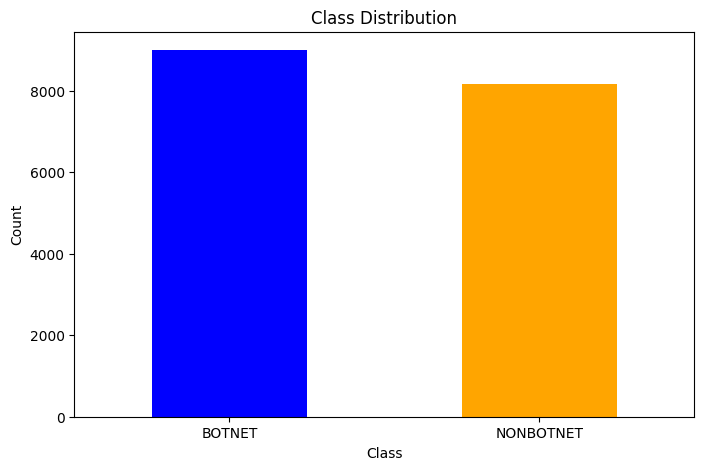

HistGradientBoosting Test Accuracy: 0.95
HistGradientBoosting Test Precision: 0.997551270278543
HistGradientBoosting Test Recall: 0.9025200775408474
HistGradientBoosting Test F1 Score: 0.9476592032567607
HistGradientBoosting Test ROC AUC Score: 0.9501455221919896

RandomForest Test Accuracy: 0.9501388888888889
RandomForest Test Precision: 0.9978567054500919
RandomForest Test Recall: 0.9025200775408474
RandomForest Test F1 Score: 0.9477970045077796
RandomForest Test ROC AUC Score: 0.9502848367642939

DecisionTree Test Accuracy: 0.9508333333333333
DecisionTree Test Precision: 0.9993866911990187
DecisionTree Test Recall: 0.9025200775408474
DecisionTree Test F1 Score: 0.94848661233993
DecisionTree Test ROC AUC Score: 0.9509814096258151

Accuracy of Majority Voting: 0.9501388888888889


['decision_tree_model.pkl']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load the concatenated CSV file
df = pd.read_csv("/content/targemergedBOT.csv")

# Define features and target
X = df[['ID', 'OD', 'IDW', 'ODW', 'IDC', 'ODC', 'BC', 'CC', 'KC', 'PR', 'Hub', 'Authority']]
y = df['Botnet']

# Check class distribution
class_distribution = df['Botnet'].value_counts()
print("Class Distribution:")
print(class_distribution)

# Plot class distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply SMOTE for oversampling
# Apply SMOTE for oversampling with custom sampling strategy
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

# Initialize classifiers with class_weight parameter
classifiers = {
    "HistGradientBoosting": HistGradientBoostingClassifier(),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced')
}

# Train and evaluate classifiers
for name, classifier in classifiers.items():
    # Cross-validation
    cv_scores = cross_val_score(classifier, X_resampled, y_resampled, cv=5, scoring='accuracy')

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='BOTNET')  # Specify the positive label as 'YES'
    recall = recall_score(y_test, y_pred, pos_label='BOTNET')  # Specify the positive label as 'YES'
    f1 = f1_score(y_test, y_pred, pos_label='BOTNET')  # Specify the positive label as 'YES'
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_pred_encoded = label_encoder.transform(y_pred)

# Calculate ROC AUC score using the numerical labels
    roc_auc = roc_auc_score(y_test_encoded, y_pred_encoded)

    print(f"{name} Test Accuracy: {accuracy}")
    print(f"{name} Test Precision: {precision}")
    print(f"{name} Test Recall: {recall}")
    print(f"{name} Test F1 Score: {f1}")
    print(f"{name} Test ROC AUC Score: {roc_auc}")
    print()

import joblib

# Save HistGradientBoostingClassifier model
joblib.dump(classifiers["HistGradientBoosting"], 'hist_gradient_boosting_model.pkl')

# Save RandomForestClassifier model
joblib.dump(classifiers["RandomForest"], 'random_forest_model.pkl')

# Save DecisionTreeClassifier model
joblib.dump(classifiers["DecisionTree"], 'decision_tree_model.pkl')



In [ ]:
!mkdir -p /etc/apt/keyrings; mkdir -p ~/.gnupg; chmod 700 ~/.gnupg
!gpg --no-default-keyring --keyring /etc/apt/keyrings/skewed.de.gpg --keyserver keyserver.ubuntu.com --recv-keys 612DEFB798507F25
!echo "deb [signed-by=/etc/apt/keyrings/skewed.de.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
# Colab uses a Python install that deviates from the system's! Bad colab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://downloads.skewed.de/apt jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Buildi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scapy

In [ ]:
# Colab uses a Python install that deviates from the system's! Bad colab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'python3-cairo' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
  Using cached pycairo-1.26.0-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: pycairo
    Found existing installation: pycairo 1.26.0
    Uninstalling pycairo-1.26.0:
      Successfully uninstalled pycairo-1.26.0
